In [1]:
import numpy as np
from scipy.stats import poisson


def check_converged(loglik, previous_loglik, tolerance=1e-4):
    """
    We have converged if the slope of the log-likelihood function falls below 'threshold',
    i.e., |f(t) - f(t-1)| / avg < threshold,
    where avg = (|f(t)| + |f(t-1)|)/2 and f(t) is log lik at iteration t.
    'threshold' defaults to 1e-4.

    This stopping criterion is from Numerical Recipes in C p423
    """
    delta_loglik = abs(loglik - previous_loglik)
    avg_loglik = (abs(loglik) + abs(previous_loglik) + np.spacing(1)) / 2

    is_increasing = loglik - previous_loglik >= -1e-3
    is_converged = (delta_loglik / avg_loglik) < tolerance

    return is_converged, is_increasing


def simulate_poisson_spikes(rate, sampling_frequency):
    """Given a rate, returns a time series of spikes.
    Parameters
    ----------
    rate : np.ndarray, shape (n_time,)
    sampling_frequency : float
    Returns
    -------
    spikes : np.ndarray, shape (n_time,)
    """
    return np.random.poisson(rate / sampling_frequency)


def simulate_two_state_poisson(
    n_time=20_000, sampling_frequency=1000, rate1=5.0, rate2=20.0
):
    rate = rate1 * np.ones((n_time,))
    rate[(n_time // 6) : (2 * n_time // 6)] = rate2
    rate[(4 * n_time // 6) : (6 * n_time // 6)] = rate2

    time = np.arange(n_time) / sampling_frequency
    spikes = simulate_poisson_spikes(rate, sampling_frequency)

    return time, rate, spikes


def poisson_log_likelihood(spikes, rate):
    return poisson.logpmf(spikes, mu=rate + np.spacing(1))


def estimate_joint_prob_state(
    causal_posterior,
    acausal_posterior,
    likelihood,
    transition_matrix,
):
    n_time, n_states = causal_posterior.shape

    # probability of state 1 in time t and state 2 in time t+1
    xi = np.zeros((n_time - 1, n_states, n_states))

    for from_state in range(n_states):
        for to_state in range(n_states):
            xi[:, from_state, to_state] = (
                causal_posterior[:-1, from_state]
                * likelihood[1:, to_state]
                * acausal_posterior[1:, to_state]
                * transition_matrix[from_state, to_state]
                / (causal_posterior[1:, to_state] + np.spacing(1))
            )

    xi = xi / xi.sum(axis=(1, 2), keepdims=True)

    return xi


def q_function(
    acausal_posterior: np.ndarray,
    joint_prob_state: np.ndarray,
    initial_conditions: np.ndarray,
    transition_matrix: np.ndarray,
    likelihood: np.ndarray,
) -> float:
    """

    Parameters
    ----------
    acausal_posterior : np.ndarray, shape (n_time, n_states)
    joint_prob_state : np.ndarray, shape (n_time-1, n_states, n_states)
    initial_conditions : np.ndarray, shape (n_states,)
    transition_matrix : np.ndarray, shape (n_states, n_states)
    likelihood : np.ndarray : np.ndarray, shape (n_time, n_states)

    Returns
    -------
    expected_complete_log_likelihood : float
    """
    expected_complete_log_likelihood = np.sum(
        acausal_posterior[0] * np.log(initial_conditions)
    )
    expected_complete_log_likelihood += np.sum(
        joint_prob_state * np.log(transition_matrix)[np.newaxis]
    )
    expected_complete_log_likelihood += np.sum(acausal_posterior * np.log(likelihood))

    return expected_complete_log_likelihood


iteration 2, likelihood: -2261.7146754327277, change: 2.9728662904071825
iteration 3, likelihood: -2257.962833778553, change: 3.7518416541747683
iteration 4, likelihood: -2253.867751722906, change: 4.095082055646799
iteration 5, likelihood: -2249.980234768297, change: 3.8875169546090547
iteration 6, likelihood: -2246.6582966002434, change: 3.321938168053748
iteration 7, likelihood: -2243.929288689231, change: 2.729007911012559
iteration 8, likelihood: -2241.5943942979684, change: 2.3348943912624236
iteration 9, likelihood: -2239.405705406205, change: 2.188688891763377
iteration 10, likelihood: -2237.168857824783, change: 2.236847581421898
iteration 11, likelihood: -2234.759967584679, change: 2.4088902401040286
iteration 12, likelihood: -2232.1047826688605, change: 2.6551849158186087
iteration 13, likelihood: -2229.1549656199318, change: 2.9498170489287077
iteration 14, likelihood: -2225.8722590721645, change: 3.2827065477672477
iteration 15, likelihood: -2222.21989175409, change: 3.652

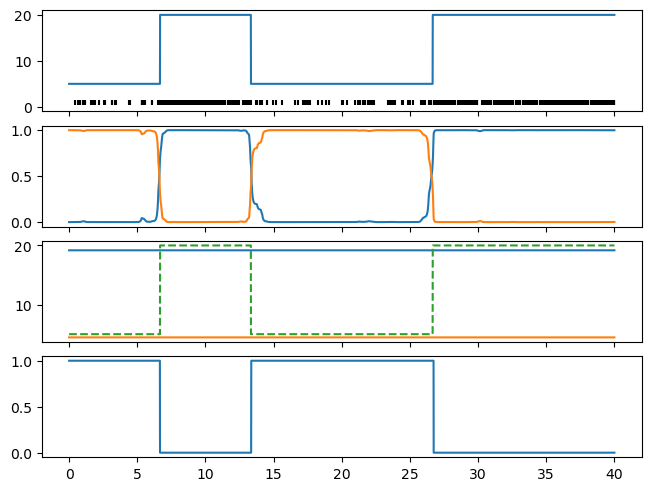

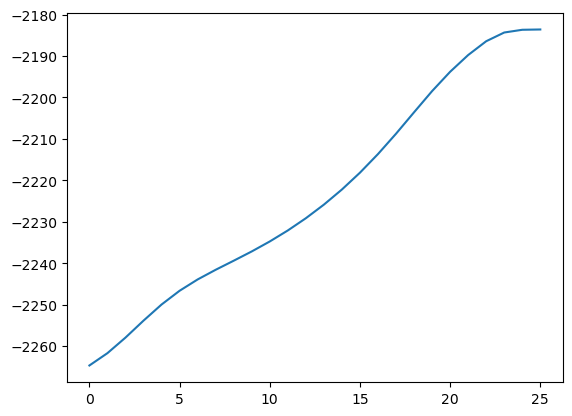

In [2]:
from src.hmm import (
    forward,
    correction_smoothing,
    update_transition_matrix_from_correction_smoothing,
    viterbi,
)

import matplotlib.pyplot as plt


sampling_frequency = 500
time, true_rate, spikes = simulate_two_state_poisson(
    sampling_frequency=sampling_frequency
)
spike_time_ind = np.nonzero(spikes)[0]


tolerance = 1e-4
max_iter = 50

data_log_likelihoods = []
ecll = []
ecll_iter = []
n_iter = 0
converged = False

n_states = 2
n_time = spikes.shape[0]
initial_conditions = np.ones((n_states,)) / n_states
transition_matrix = np.asarray([[0.98, 0.02], [0.02, 0.98]])
is_training = np.ones((n_time,))
is_training[: n_time // 2] = 0.0

while not converged and (n_iter < max_iter):
    predict_rates = np.asarray(
        (
            np.average(spikes, weights=is_training.astype(float)),
            np.average(spikes, weights=1 - is_training.astype(float)),
        )
    )[np.newaxis]
    predict_rates = np.ones((n_time, 1)) * predict_rates
    likelihood = np.exp(poisson_log_likelihood(spikes[:, np.newaxis], predict_rates))

    # Expectation step
    causal_posterior, data_log_likelihood, scaling = forward(
        initial_conditions, likelihood, transition_matrix
    )

    acausal_posterior = correction_smoothing(causal_posterior, transition_matrix)

    # Q function check
    joint_prob_state = estimate_joint_prob_state(
        causal_posterior,
        acausal_posterior,
        likelihood,
        transition_matrix,
    )
    ecll.append(
        q_function(
            acausal_posterior,
            joint_prob_state,
            initial_conditions,
            transition_matrix,
            likelihood,
        )
    )
    ecll_iter.append(n_iter)

    # Maximization step
    transition_matrix = update_transition_matrix_from_correction_smoothing(
        causal_posterior,
        acausal_posterior,
        likelihood,
        transition_matrix,
    )

    is_training = acausal_posterior[:, 0]
    initial_conditions = acausal_posterior[0]

    # Q function check

    predict_rates = np.asarray(
        (
            np.average(spikes, weights=is_training.astype(float)),
            np.average(spikes, weights=1 - is_training.astype(float)),
        )
    )[np.newaxis]
    predict_rates = np.ones((n_time, 1)) * predict_rates
    likelihood = np.exp(poisson_log_likelihood(spikes[:, np.newaxis], predict_rates))

    joint_prob_state = estimate_joint_prob_state(
        causal_posterior,
        acausal_posterior,
        likelihood,
        transition_matrix,
    )
    ecll.append(
        q_function(
            acausal_posterior,
            joint_prob_state,
            initial_conditions,
            transition_matrix,
            likelihood,
        )
    )
    ecll_iter.append(n_iter)

    # Stats
    n_iter += 1

    data_log_likelihoods.append(data_log_likelihood)
    if n_iter > 1:
        log_likelihood_change = data_log_likelihoods[-1] - data_log_likelihoods[-2]
        converged, increasing = check_converged(
            data_log_likelihoods[-1], data_log_likelihoods[-2], tolerance
        )

        print(
            f"iteration {n_iter}, "
            f"likelihood: {data_log_likelihoods[-1]}, "
            f"change: {log_likelihood_change}"
        )

predicted_state = viterbi(initial_conditions, likelihood, transition_matrix)[0]

fig, axes = plt.subplots(4, 1, constrained_layout=True, sharex=True)
axes[0].plot(time, true_rate)
axes[0].eventplot(time[spike_time_ind], color="black")

axes[1].plot(time, acausal_posterior)
axes[2].plot(time, predict_rates * sampling_frequency)
axes[2].plot(time, true_rate, linestyle="--")
axes[3].plot(time, predicted_state)

plt.figure()
plt.plot(data_log_likelihoods)


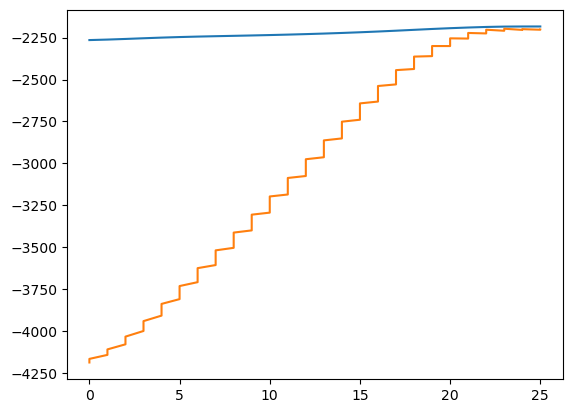

In [3]:
plt.plot(np.arange(n_iter), data_log_likelihoods)
plt.plot(ecll_iter, ecll)


In [4]:
is_state1 = true_rate > 10
true_transition = np.asarray(
    [
        [
            (~is_state1[:-1] & ~is_state1[1:]).sum(),
            (~is_state1[:-1] & is_state1[1:]).sum(),
        ],
        [
            (is_state1[:-1] & ~is_state1[1:]).sum(),
            (is_state1[:-1] & is_state1[1:]).sum(),
        ],
    ]
).astype(float)
true_transition /= true_transition.sum(axis=1, keepdims=True)
true_transition, true_transition - transition_matrix


(array([[9.99800000e-01, 2.00000000e-04],
        [1.00010001e-04, 9.99899990e-01]]),
 array([[-8.78142955e-05,  8.78142955e-05],
        [-1.18025012e-04,  1.18025012e-04]]))

In [5]:
def estimate_joint_prob_state2(
    causal_posterior,
    likelihood,
    scaled_backward_posterior,
    transition_matrix,
):
    n_states = causal_posterior.shape[1]
    xi = np.empty((n_time - 1, n_states, n_states))

    for from_state in range(n_states):
        for to_state in range(n_states):
            xi[:, from_state, to_state] = (
                causal_posterior[:-1, from_state]
                * likelihood[1:, to_state]
                * scaled_backward_posterior[1:, to_state]
                * transition_matrix[from_state, to_state]
                )

    xi = xi / xi.sum(axis=(1, 2), keepdims=True)
    
    return xi


iteration 2, likelihood: -2354.6726116830714, change: 1.8992901545925633
iteration 3, likelihood: -2352.3566809031627, change: 2.31593077990874
iteration 4, likelihood: -2349.895688758883, change: 2.4609921442797713
iteration 5, likelihood: -2347.6160496363136, change: 2.2796391225692787
iteration 6, likelihood: -2345.7482983201708, change: 1.8677513161428578
iteration 7, likelihood: -2344.354923609277, change: 1.3933747108935677
iteration 8, likelihood: -2343.3649398785046, change: 0.9899837307725647
iteration 9, likelihood: -2342.6539108211427, change: 0.711029057361884
iteration 10, likelihood: -2342.105605768893, change: 0.5483050522498161
iteration 11, likelihood: -2341.636421292285, change: 0.46918447660800666
iteration 12, likelihood: -2341.194679496673, change: 0.4417417956119607
iteration 13, likelihood: -2340.7510593611, change: 0.4436201355729281
iteration 14, likelihood: -2340.28925155246, change: 0.4618078086400601
iteration 15, likelihood: -2339.799525380634, change: 0.48

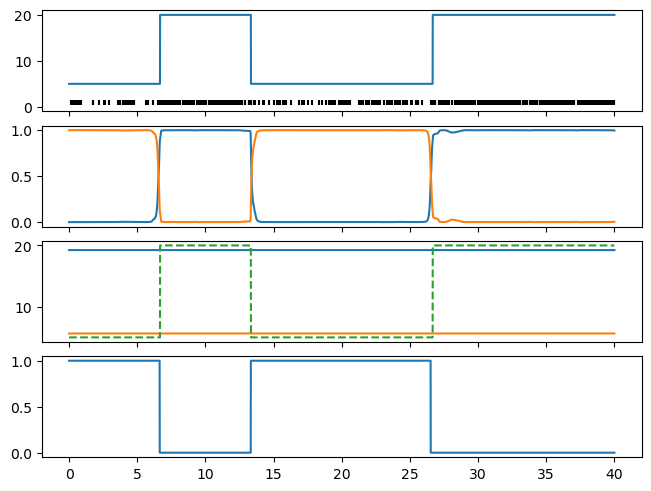

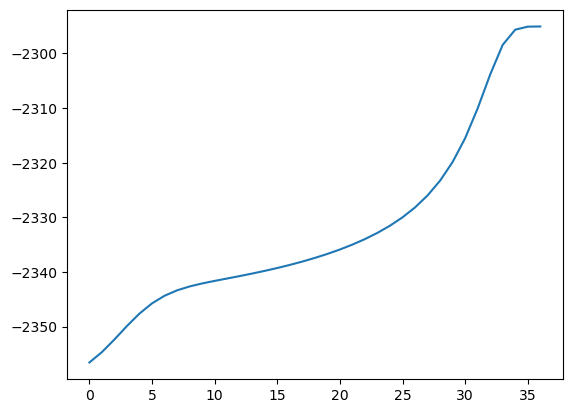

In [6]:
from src.hmm import (
    forward,
    backward,
    correction_smoothing,
    update_transition_matrix_from_parallel_smoothing,
    get_acausal_posterior_from_parallel_smoothing,
    viterbi,
)

import matplotlib.pyplot as plt


sampling_frequency = 500
time, true_rate, spikes = simulate_two_state_poisson(
    sampling_frequency=sampling_frequency
)
spike_time_ind = np.nonzero(spikes)[0]


tolerance = 1e-4
max_iter = 50

data_log_likelihoods = []
ecll = []
ecll_iter = []
n_iter = 0
converged = False

n_states = 2
n_time = spikes.shape[0]
initial_conditions = np.ones((n_states,)) / n_states
transition_matrix = np.asarray([[0.98, 0.02], [0.02, 0.98]])
is_training = np.ones((n_time,))
is_training[: n_time // 2] = 0.0

while not converged and (n_iter < max_iter):
    predict_rates = np.asarray(
        (
            np.average(spikes, weights=is_training.astype(float)),
            np.average(spikes, weights=1 - is_training.astype(float)),
        )
    )[np.newaxis]
    predict_rates = np.ones((n_time, 1)) * predict_rates
    likelihood = np.exp(poisson_log_likelihood(spikes[:, np.newaxis], predict_rates))

    # Expectation step
    causal_posterior, data_log_likelihood, scaling = forward(
        initial_conditions, likelihood, transition_matrix
    )

    scaled_backward_posterior = backward(
        initial_conditions,
        likelihood,
        transition_matrix,
        scaling,
    )
    
    acausal_posterior = get_acausal_posterior_from_parallel_smoothing(
        causal_posterior, scaled_backward_posterior
    )

    # Q function check
    joint_prob_state = estimate_joint_prob_state2(
        causal_posterior,
        likelihood,
        scaled_backward_posterior,
        transition_matrix,
    )
    ecll.append(
        q_function(
            acausal_posterior,
            joint_prob_state,
            initial_conditions,
            transition_matrix,
            likelihood,
        )
    )
    ecll_iter.append(n_iter)

    # Maximization step
    transition_matrix = update_transition_matrix_from_parallel_smoothing(
        causal_posterior,
        scaled_backward_posterior,
        likelihood,
        transition_matrix,
    )

    is_training = acausal_posterior[:, 0]
    initial_conditions = acausal_posterior[0]

    # Q function check

    predict_rates = np.asarray(
        (
            np.average(spikes, weights=is_training.astype(float)),
            np.average(spikes, weights=1 - is_training.astype(float)),
        )
    )[np.newaxis]
    predict_rates = np.ones((n_time, 1)) * predict_rates
    likelihood = np.exp(poisson_log_likelihood(spikes[:, np.newaxis], predict_rates))

    joint_prob_state = estimate_joint_prob_state2(
        causal_posterior,
        likelihood,
        scaled_backward_posterior,
        transition_matrix,
    )
    ecll.append(
        q_function(
            acausal_posterior,
            joint_prob_state,
            initial_conditions,
            transition_matrix,
            likelihood,
        )
    )
    ecll_iter.append(n_iter)

    # Stats
    n_iter += 1

    data_log_likelihoods.append(data_log_likelihood)
    if n_iter > 1:
        log_likelihood_change = data_log_likelihoods[-1] - data_log_likelihoods[-2]
        converged, increasing = check_converged(
            data_log_likelihoods[-1], data_log_likelihoods[-2], tolerance
        )

        print(
            f"iteration {n_iter}, "
            f"likelihood: {data_log_likelihoods[-1]}, "
            f"change: {log_likelihood_change}"
        )

predicted_state = viterbi(initial_conditions, likelihood, transition_matrix)[0]

fig, axes = plt.subplots(4, 1, constrained_layout=True, sharex=True)
axes[0].plot(time, true_rate)
axes[0].eventplot(time[spike_time_ind], color="black")

axes[1].plot(time, acausal_posterior)
axes[2].plot(time, predict_rates * sampling_frequency)
axes[2].plot(time, true_rate, linestyle="--")
axes[3].plot(time, predicted_state)

plt.figure()
plt.plot(data_log_likelihoods)


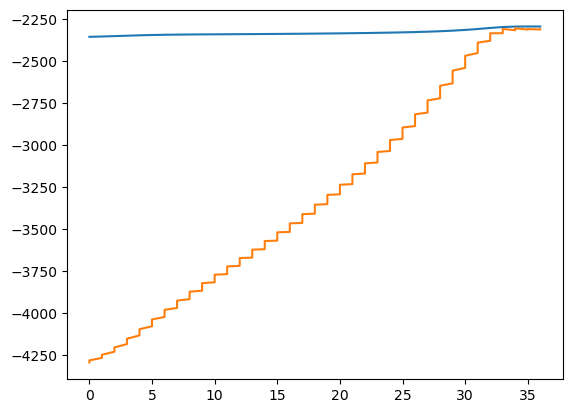

In [7]:
plt.plot(np.arange(n_iter), data_log_likelihoods)
plt.plot(ecll_iter, ecll)


In [41]:
import numpy as np
from scipy.optimize import minimize

import jax
import jax.numpy as jnp
import jax.scipy as jsp

def fit_regression(weights):

    design_matrix = np.ones((weights.shape[0], 1))

    @jax.jit
    def neglogp(
        coefficients, spikes=spikes, design_matrix=design_matrix, weights=weights
    ):
        conditional_intensity = jnp.exp(design_matrix @ coefficients)
        log_likelihood = weights * jax.scipy.stats.poisson.logpmf(
            spikes.astype(float), conditional_intensity + np.spacing(1)
        )
        return -log_likelihood.sum()

    dlike = jax.grad(neglogp)
    dlike2 = jax.hessian(neglogp)

    res = minimize(
        neglogp, x0=np.ones((design_matrix.shape[1],)), method="Newton-CG", jac=dlike, hess=dlike2
    )
    conditional_intensity = jnp.exp(design_matrix @ res.x)

    return conditional_intensity.squeeze()


In [42]:
from src.hmm import (
    forward,
    correction_smoothing,
    update_transition_matrix_from_correction_smoothing,
    viterbi,
    check_converged,
)

import matplotlib.pyplot as plt


sampling_frequency = 500
time, true_rate, spikes = simulate_two_state_poisson(
    sampling_frequency=sampling_frequency
)
spike_time_ind = np.nonzero(spikes)[0]


tolerance = 1e-4
max_iter = 50

data_log_likelihoods = []
ecll = []
ecll_iter = []
n_iter = 0
converged = False

n_states = 2
n_time = spikes.shape[0]
initial_conditions = np.ones((n_states,)) / n_states
transition_matrix = np.asarray([[0.98, 0.02], [0.02, 0.98]])
is_training = np.ones((n_time,))
is_training[: n_time // 2] = 0.0

while not converged and (n_iter < max_iter):
    
    predict_rates = np.stack(
        (
            fit_regression(is_training.astype(float)),
            fit_regression(1 - is_training.astype(float)),
        ),
        axis=1
    )
    
    # predict_rates = np.asarray(
    #     (
    #         np.average(spikes, weights=is_training.astype(float)),
    #         np.average(spikes, weights=1 - is_training.astype(float)),
    #     )
    # )[np.newaxis]
    # predict_rates = np.ones((n_time, 1)) * predict_rates
    
    likelihood = np.exp(poisson_log_likelihood(spikes[:, np.newaxis], predict_rates))

    # Expectation step
    causal_posterior, data_log_likelihood, scaling = forward(
        initial_conditions, likelihood, transition_matrix
    )

    acausal_posterior = correction_smoothing(causal_posterior, transition_matrix)

    # Maximization step
    transition_matrix = update_transition_matrix_from_correction_smoothing(
        causal_posterior,
        acausal_posterior,
        likelihood,
        transition_matrix,
    )

    is_training = acausal_posterior[:, 0]
    initial_conditions = acausal_posterior[0]

    # Stats
    n_iter += 1

    data_log_likelihoods.append(data_log_likelihood)
    if n_iter > 1:
        log_likelihood_change = data_log_likelihoods[-1] - data_log_likelihoods[-2]
        converged, increasing = check_converged(
            data_log_likelihoods[-1], data_log_likelihoods[-2], tolerance
        )

        print(
            f"iteration {n_iter}, "
            f"likelihood: {data_log_likelihoods[-1]}, "
            f"change: {log_likelihood_change}"
        )
    else:
        print(
            f"iteration {n_iter}, "
            f"likelihood: {data_log_likelihoods[-1]}"
        )

predicted_state = viterbi(initial_conditions, likelihood, transition_matrix)[0]


iteration 1, likelihood: -2304.8518050602293
iteration 2, likelihood: -2303.0311932932345, change: 1.8206117669947162
iteration 3, likelihood: -2300.5681873760477, change: 2.4630059171868197
iteration 4, likelihood: -2297.6205452163904, change: 2.9476421596573346
iteration 5, likelihood: -2294.5450668851213, change: 3.075478331269096
iteration 6, likelihood: -2291.7486488852524, change: 2.796417999868936
iteration 7, likelihood: -2289.464040753094, change: 2.284608132158155
iteration 8, likelihood: -2287.7066137627776, change: 1.7574269903166169
iteration 9, likelihood: -2286.3333538110646, change: 1.373259951712953
iteration 10, likelihood: -2285.1650417289225, change: 1.1683120821421653
iteration 11, likelihood: -2284.054516746617, change: 1.1105249823053782
iteration 12, likelihood: -2282.899861170494, change: 1.1546555761228774
iteration 13, likelihood: -2281.632986458498, change: 1.2668747119960244
iteration 14, likelihood: -2280.2023573173437, change: 1.4306291411544407
iteration

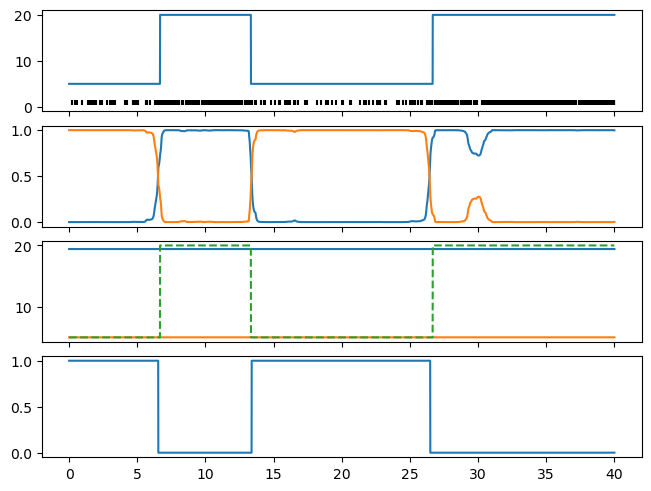

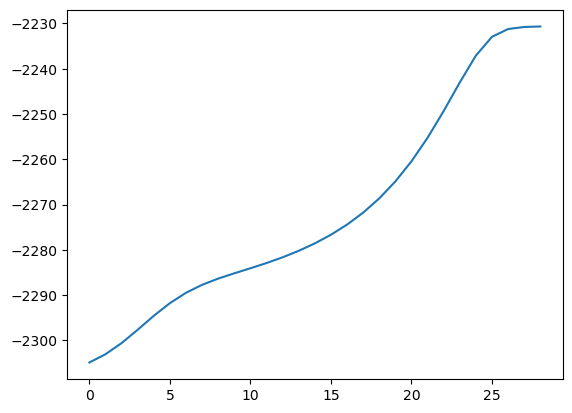

In [44]:
fig, axes = plt.subplots(4, 1, constrained_layout=True, sharex=True)
axes[0].plot(time, true_rate)
axes[0].eventplot(time[spike_time_ind], color="black")

axes[1].plot(time, acausal_posterior)
axes[2].plot(time, predict_rates * sampling_frequency)
axes[2].plot(time, true_rate, linestyle="--")
axes[3].plot(time, predicted_state)

plt.figure()
plt.plot(data_log_likelihoods)

In [19]:
from src.hmm import (
    forward,
    correction_smoothing,
    update_transition_matrix_from_correction_smoothing,
    viterbi,
    check_converged,
)

import matplotlib.pyplot as plt


sampling_frequency = 500
time, true_rate, spikes = simulate_two_state_poisson(
    sampling_frequency=sampling_frequency
)
spike_time_ind = np.nonzero(spikes)[0]


tolerance = 1e-4
max_iter = 50

data_log_likelihoods = []
ecll = []
ecll_iter = []
n_iter = 0
converged = False

n_states = 2
n_time = spikes.shape[0]
initial_conditions = np.ones((n_states,)) / n_states
transition_matrix = np.asarray([[0.98, 0.02], [0.02, 0.98]])
is_training = np.ones((n_time,))
is_training[: n_time // 2] = 0.0


likelihood1 = np.exp(
    np.stack(
        (
            fit_regression(is_training.astype(float).squeeze()),
            fit_regression(1 - is_training.astype(float).squeeze()),
        ),
        axis=1,
    )
)

predict_rates = np.asarray(
    (
        np.average(spikes, weights=is_training.astype(float)),
        np.average(spikes, weights=1 - is_training.astype(float)),
    )
)[np.newaxis]
predict_rates = np.ones((n_time, 1)) * predict_rates
likelihood2 = np.exp(poisson_log_likelihood(spikes[:, np.newaxis], predict_rates))

In [23]:
likelihood1.sum(axis=0), likelihood2.sum(axis=0)

(array([19440.176, 19616.4  ], dtype=float32),
 array([18971.51235059, 19146.40652487]))

In [24]:
predict_rates

array([[0.0293, 0.0199],
       [0.0293, 0.0199],
       [0.0293, 0.0199],
       ...,
       [0.0293, 0.0199],
       [0.0293, 0.0199],
       [0.0293, 0.0199]])

In [27]:
weights = 1 - is_training.astype(float).squeeze()
design_matrix = np.ones((weights.shape[0], 1))

@jax.jit
def neglogp(
    coefficients, spikes=spikes, design_matrix=design_matrix, weights=weights
):
    conditional_intensity = jnp.exp(design_matrix @ coefficients)
    log_likelihood = weights * jax.scipy.stats.poisson.logpmf(
        spikes.astype(float), conditional_intensity + np.spacing(1)
    )
    return -log_likelihood.sum()

dlike = jax.grad(neglogp)
dlike2 = jax.hessian(neglogp)

res = minimize(
    neglogp, x0=np.ones((design_matrix.shape[1],)), method="Newton-CG", jac=dlike, hess=dlike2
)
conditional_intensity = jnp.exp(design_matrix @ res.x)
conditional_intensity

np.exp(poisson_log_likelihood(spikes[:, np.newaxis], conditional_intensity))

array([[0.98029677, 0.98029677, 0.98029677, ..., 0.98029677, 0.98029677,
        0.98029677],
       [0.98029677, 0.98029677, 0.98029677, ..., 0.98029677, 0.98029677,
        0.98029677],
       [0.98029677, 0.98029677, 0.98029677, ..., 0.98029677, 0.98029677,
        0.98029677],
       ...,
       [0.98029677, 0.98029677, 0.98029677, ..., 0.98029677, 0.98029677,
        0.98029677],
       [0.98029677, 0.98029677, 0.98029677, ..., 0.98029677, 0.98029677,
        0.98029677],
       [0.98029677, 0.98029677, 0.98029677, ..., 0.98029677, 0.98029677,
        0.98029677]])

In [28]:
likelihood1

array([[1.       , 0.9802963],
       [1.       , 0.9802963],
       [1.       , 0.9802963],
       ...,
       [0.9711089, 1.       ],
       [0.9711089, 1.       ],
       [0.9711089, 1.       ]], dtype=float32)